# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Assessing data

In [1]:
#Import libraries and load datasets.
import pandas as pd
import numpy as np
import seaborn as sn
import math
import json
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
portfolio.describe()

,difficulty,duration,reward
count,10.000000,10.000000,10.000000
mean,7.700000,6.500000,4.200000
std,5.831905,2.321398,3.583915
min,0.000000,3.000000,0.000000
25%,5.000000,5.000000,2.000000
50%,8.500000,7.000000,4.000000
75%,10.000000,7.000000,5.000000
max,20.000000,10.000000,10.000000


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


In [6]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [7]:
transcript.describe()

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


# Cleaning

In [8]:
#getting dummy for the channels 
channels =pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
#join datasets
portfolio = pd.concat([portfolio, channels], axis = 1)
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [9]:
portfolio.rename(columns={'id' :'offer_id'},inplace=True)

In [10]:
#get date time
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [11]:
profile.rename(columns={'id' :'person'},inplace=True)

In [12]:
# expand the value columns and merge offer id 
transcript['offer_id'] = transcript.value.apply(lambda x: x[list(x.keys())[0]] if list(x.keys())[0] in ['offer id','offer_id'] else None)
transcript['amount'] = transcript.value.apply(lambda x: x['amount'] if 'amount' in x.keys() else None)
#drop value
transcript.drop(columns=['value'], inplace=True)

In [13]:
transcript.head()

,event,person,time,offer_id,amount
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [14]:
transcript.describe()

,time,amount
count,306534.000000,138953.000000
mean,366.382940,12.777356
std,200.326314,30.250529
min,0.000000,0.050000
25%,186.000000,2.780000
50%,408.000000,8.890000
75%,528.000000,18.070000
max,714.000000,1062.280000


In [15]:
#creat data set for amount spent
#amount data set
amount_df = pd.merge(transcript, profile, on='person')
amount_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306534 entries, 0 to 306533
Data columns (total 9 columns):
event               306534 non-null object
person              306534 non-null object
time                306534 non-null int64
offer_id            167581 non-null object
amount              138953 non-null float64
age                 306534 non-null int64
became_member_on    306534 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 23.4+ MB


In [16]:
#summary
amount_df['amount'].describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [17]:
#mak copy to remove outliers
amount_df1=amount_df.copy()
amount_df1=amount_df1.dropna(subset=['amount'],inplace=True)
amount_df1 = amount_df[amount_df["amount"] != 0]
q = amount_df["amount"].quantile(0.9)
#filter with q
amount_df1 = amount_df[amount_df["amount"] < q]

In [18]:
#merge df1 with portfolio on offer id
df= pd.merge(amount_df,portfolio,on=['offer_id'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 18 columns):
event               167581 non-null object
person              167581 non-null object
time                167581 non-null int64
offer_id            167581 non-null object
amount              0 non-null float64
age                 167581 non-null int64
became_member_on    167581 non-null datetime64[ns]
gender              148805 non-null object
income              148805 non-null float64
channels            167581 non-null object
difficulty          167581 non-null int64
duration            167581 non-null int64
offer_type          167581 non-null object
reward              167581 non-null int64
email               167581 non-null uint8
mobile              167581 non-null uint8
social              167581 non-null uint8
web                 167581 non-null uint8
dtypes: datetime64[ns](1), float64(2), int64(5), object(6), uint8(4)
memory usage: 19.8+ MB


In [19]:
#test
df.head()

,event,person,time,offer_id,amount,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1


# EDA

### Gender

In [20]:
df['gender'].describe()

count     148805
unique         3
top            M
freq       82896
Name: gender, dtype: object

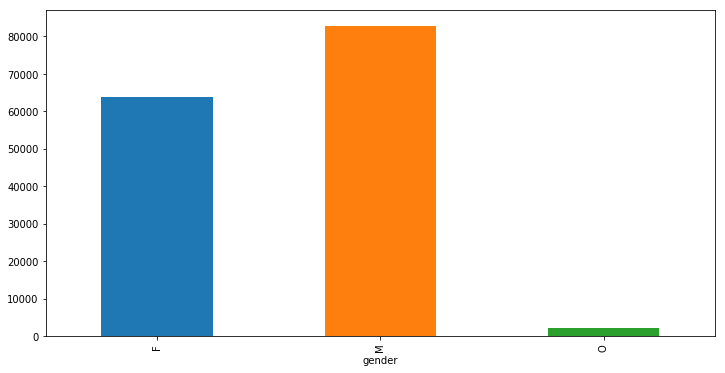

In [21]:
#gender count
plt.figure(figsize = [12, 6])
df.groupby('gender')['person'].count().plot(kind='bar')

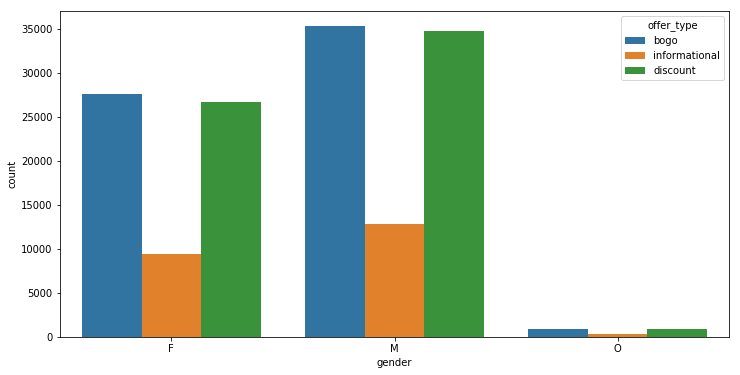

In [22]:
#gender and offer types 
plt.figure(figsize = [12, 6])
sn.countplot(x="gender", hue="offer_type",data=df)

### Age

In [23]:
#age descrition 
df['age'].describe()

count    167581.000000
mean         61.862616
std          25.693155
min          18.000000
25%          45.000000
50%          58.000000
75%          72.000000
max         118.000000
Name: age, dtype: float64

In [24]:
#remove outlier
#get quantile 
q = df["age"].quantile(0.99)
#filter with q
df = df[df["age"] < q]

### Income

In [25]:
#summary of income
df['income'].describe()

count    148805.000000
mean      66414.119149
std       21496.947967
min       30000.000000
25%       51000.000000
50%       65000.000000
75%       81000.000000
max      120000.000000
Name: income, dtype: float64

## Age and income vs gender

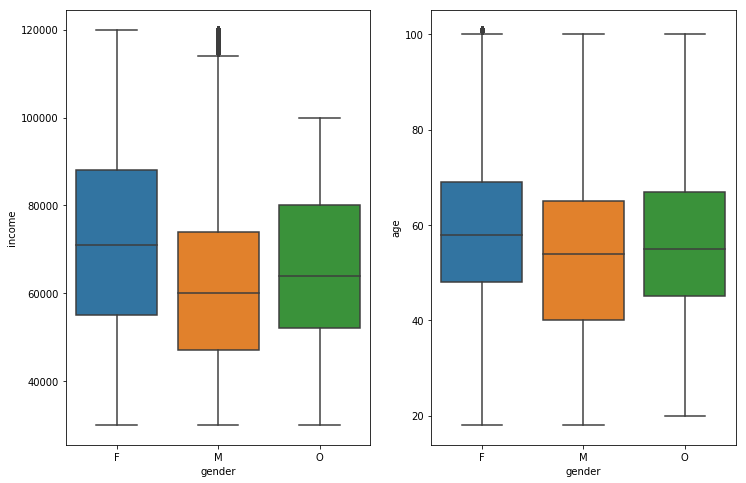

In [26]:
#stats summaries of age and income

np.seterr(divide = 'ignore')
plt.figure(figsize = [12, 8])
# left plot: 
plt.subplot(1, 2, 1)
sn.boxplot(data = df, x = 'gender', y = 'income')

# central plot: 
plt.subplot(1, 2, 2)
sn.boxplot(data = df, x = 'gender', y = 'age')


## Distribution of amount 

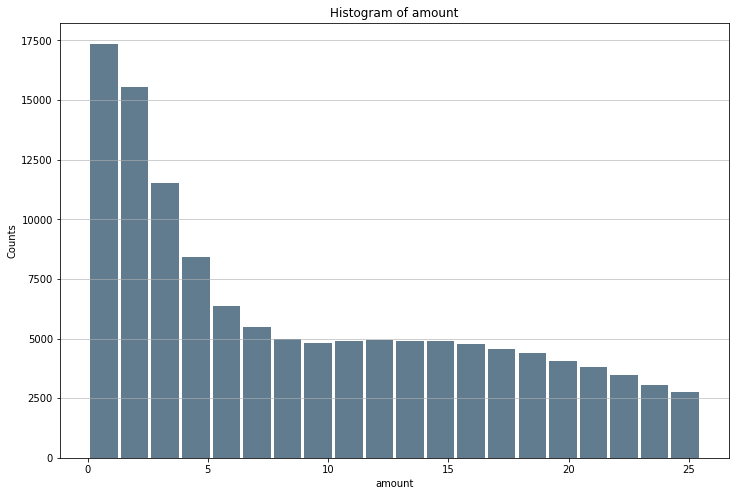

In [27]:
#distribution of amount
plt.figure(figsize = [12, 8])
plt.hist(amount_df1['amount'],bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of amount')
plt.xlabel('amount')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)

### Distribution of income and age

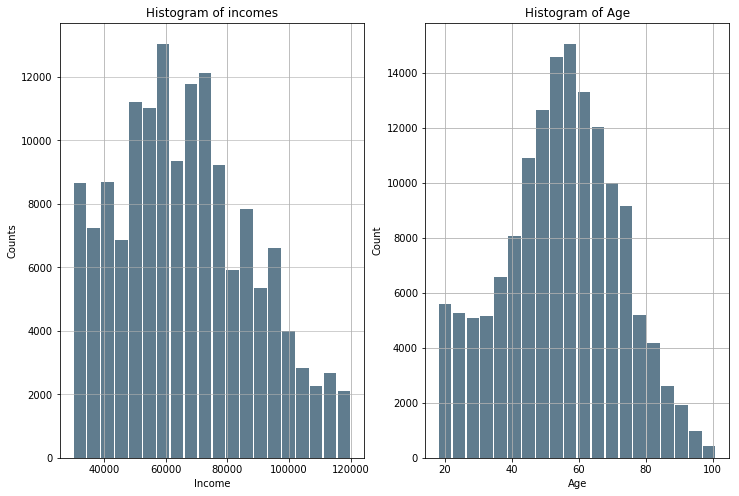

In [28]:
#distribution age , income
#prep
np.seterr(divide = 'ignore')
plt.figure(figsize = [12, 8])
# left plot: 
plt.subplot(1, 2, 1)
#plot
df['income'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Histogram of incomes')
plt.xlabel('Income')
plt.ylabel('Counts')
plt.grid(axis='y', alpha=0.75)


# central plot: 
plt.subplot(1, 2, 2)
df['age'].plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histogram of Age')
plt.grid(True)
plt.show()




# Which groups of people are most responsive to each type of offer

and how best to present each type of offer.
Age, income, channels, gender, and difficulty

In [29]:
#create copy for modeling
df1=df.copy()
df1.head()

,event,person,time,offer_id,amount,age,became_member_on,gender,income,channels,difficulty,duration,offer_type,reward,email,mobile,social,web
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75,2017-05-09,F,100000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
3,offer received,e2127556f4f64592b11af22de27a7932,408,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1
4,offer viewed,e2127556f4f64592b11af22de27a7932,420,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,68,2018-04-26,M,70000.0,"[web, email, mobile]",5,7,bogo,5,1,1,0,1


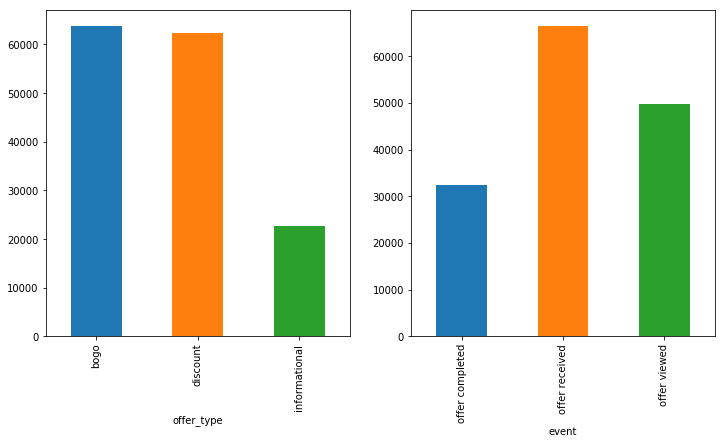

In [30]:
#plot of offer type and event counts
plt.figure(figsize = [12, 6])
plt.subplot(1, 2, 1)

df1.groupby('offer_type')['person'].count().plot(kind='bar')
plt.subplot(1, 2, 2)
df1.groupby('event')['person'].count().plot(kind='bar')


In [31]:
#creat data set for each offer type
bogo = df1[df1['offer_type']=='bogo']
discount = df1[df1['offer_type']=='discount']
discount_offer_completed = discount[discount['event']== 'offer completed']

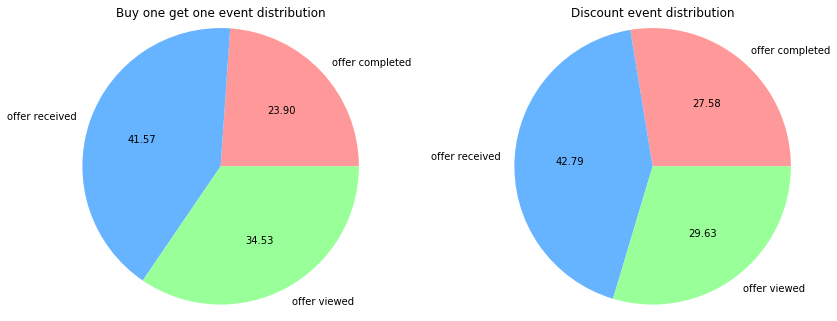

In [32]:
#compare events across offer type
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1], aspect=1)
ax1.pie(bogo.groupby('event').size().values,labels = bogo.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Buy one get one event distribution')
ax2 = fig.add_axes([1, .0, 1, 1], aspect=1)
ax2.pie(discount.groupby('event').size().values,labels = discount.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Discount event distribution')
plt.show()

# offer type based on gender and event


In [33]:
#offer type based on gender and event
bogo_f= bogo[bogo['gender']=='F']
bogo_m= bogo[bogo['gender']=='M']

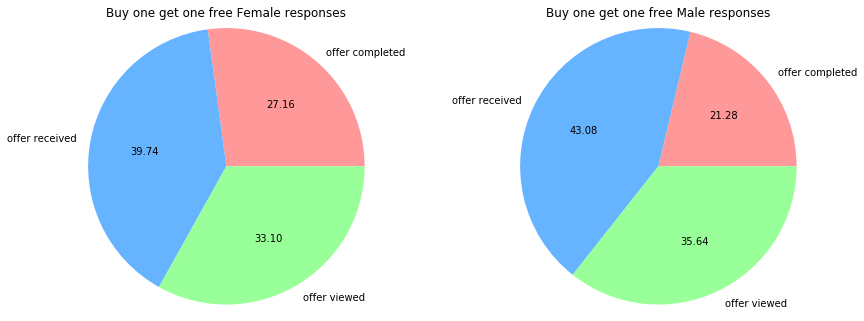

In [34]:
#compare events across offer type
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1], aspect=1)
ax1.pie(bogo_f.groupby('event').size().values,labels = bogo.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Buy one get one free Female responses')
ax2 = fig.add_axes([1, .0, 1, 1], aspect=1)
ax2.pie(bogo_m.groupby('event').size().values,labels = discount.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Buy one get one free Male responses')
plt.show()

In [35]:
discount_f= discount[discount['gender']=='F']
discount_m= discount[discount['gender']=='M']

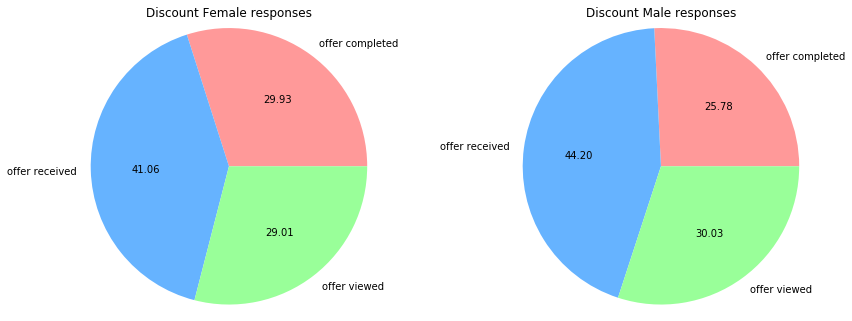

In [36]:
#compare events across offer type
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
fig = plt.figure()
ax1 = fig.add_axes([0, 0, 1, 1], aspect=1)
ax1.pie(discount_f.groupby('event').size().values,labels = bogo.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Discount Female responses')
ax2 = fig.add_axes([1, .0, 1, 1], aspect=1)
ax2.pie(discount_m.groupby('event').size().values,labels = discount.groupby('event').size().index,autopct='%.2f',colors=colors,radius = 1.2)
plt.title('Discount Male responses')
plt.show()

# Offer completed ML

In [37]:
#get dummies for cats data
df3 = pd.get_dummies(df1, columns=['offer_type','event','gender'])

In [38]:
#drop 'channels','amount','became_member_on','offer_id','person'
df3.drop(columns=['channels','amount','became_member_on','offer_id','person'],inplace=True)

In [39]:
#test
df3.head()

,time,age,income,difficulty,duration,reward,email,mobile,social,web,offer_type_bogo,offer_type_discount,offer_type_informational,event_offer completed,event_offer received,event_offer viewed,gender_F,gender_M,gender_O
0,0,75,100000.0,5,7,5,1,1,0,1,1,0,0,0,1,0,1,0,0
1,6,75,100000.0,5,7,5,1,1,0,1,1,0,0,0,0,1,1,0,0
2,132,75,100000.0,5,7,5,1,1,0,1,1,0,0,1,0,0,1,0,0
3,408,68,70000.0,5,7,5,1,1,0,1,1,0,0,0,1,0,0,1,0
4,420,68,70000.0,5,7,5,1,1,0,1,1,0,0,0,0,1,0,1,0


In [40]:
df3.columns

Index(['time', 'age', 'income', 'difficulty', 'duration', 'reward', 'email',
       'mobile', 'social', 'web', 'offer_type_bogo', 'offer_type_discount',
       'offer_type_informational', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'gender_F', 'gender_M',
       'gender_O'],
      dtype='object')

In [41]:
#define x and y for training
X = df3.drop(columns=['event_offer completed'])
y = df3['event_offer completed']
#split data into test and train
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [42]:
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_validation.shape[0]))

Training set has 119044 samples.
Testing set has 29761 samples.


In [43]:
#Spot Check Algorithms
models = []
models.append(('RFC', RandomForestClassifier(max_depth=5)))
models.append(('KMS', KMeans()))
models.append(('NB', GaussianNB()))


# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = StratifiedKFold()
    cv_results = cross_val_score(model, X_train, Y_train, cv=3, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))


RFC: 0.979142 (0.028788)
KMS: 0.159588 (0.002437)
NB: 0.903473 (0.001533)


GaussianNB() gives more desired result

In [44]:
# Make predictions on validation dataset
model = GaussianNB()
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [45]:
print(confusion_matrix(Y_validation, predictions))


[[23113   104]
 [ 2737  3807]]


In [46]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.904539498001
             precision    recall  f1-score   support

          0       0.89      1.00      0.94     23217
          1       0.97      0.58      0.73      6544

avg / total       0.91      0.90      0.90     29761



# Reflection
I found this project interesting with freedom to explore its data. The model was limited due to the imbalaced data 

# Improvement
Future studies could benefit from adding additional information such as location, time and education level. This could help improve the model with relevant information. 